# An overview of `causallib` evaluation plots

To make it easier to assess the quality of the causal models, `causallib` supplies a number of evaluation plots.
The plots are accessed by first running `causallib.evaluation.evaluate` on a model and data. More useful results are obtained when the cross-validation evaluation is used, by supplying `cv="auto"` to `evaluate()`. 
The resulting object has a method `plot_all` to create all of its supported plots.  

In this notebook we detail each plot and offer brief comments on how it may be useful for assessing the causal model.  
For more detailed discussion, see the notebooks for each model (most of which include plots), the package documentation, or our manuscript [An Evaluation Toolkit to Guide Model Selection and Cohort Definition in Causal Inference](https://arxiv.org/abs/1906.00442).

In [1]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from causallib.datasets import load_nhefs
from causallib.estimation import IPW, StratifiedStandardization
from causallib.evaluation import evaluate

In [2]:
data = load_nhefs()

## Propensity plots

In [3]:
ipw = IPW(LogisticRegression(max_iter=2000), clip_min=0.05, clip_max=0.95)
ipw.fit(data.X, data.a, data.y)
results = evaluate(ipw, data.X, data.a, data.y, cv="auto")
results.all_plot_names

frozenset({'calibration',
           'covariate_balance_love',
           'covariate_balance_slope',
           'pr_curve',
           'roc_curve',
           'weight_distribution'})

### Covariate Balance
Covariate balance plots show how well the weighting (most commonly - inverse propensity weighting) reduces the imbalance in covariates between treatment and control groups. If the weight calculation was effective, the imbalance should be lower after weighting, and if the model is not overfit this should be true for the validation set also. Often a threshold of 0.1 is taken as a cutoff for "imbalanced" features. In this case, the weighting worked but for the validation data, several features are still above 0.1. Causallib supplies three versions of this plot: the popular `kind="love"`, a slope-graph variation of it with `kind="slope"`, and a scatterplot version (`kind="slope"`) usually most suitable when wokring with a large number of covariates.

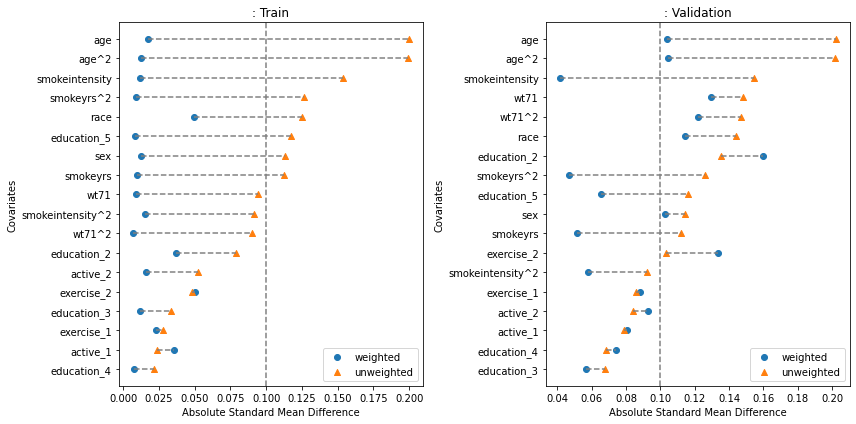

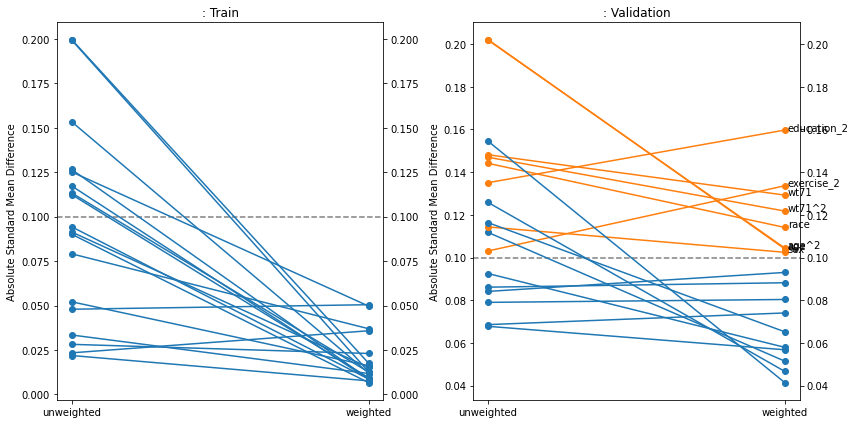

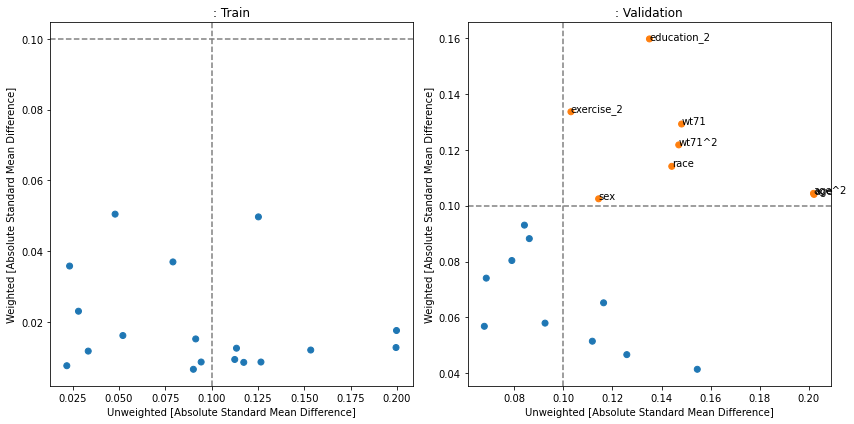

In [4]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_covariate_balance(kind="love", phase="train", ax=a0, thresh=0.1)
results.plot_covariate_balance(kind="love", phase="valid", ax=a1, thresh=0.1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
plt.tight_layout();


fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_covariate_balance(kind="slope", phase="train", ax=a0, thresh=0.1)
results.plot_covariate_balance(kind="slope", phase="valid", ax=a1, thresh=0.1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
plt.tight_layout();


fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_covariate_balance(kind="scatter", phase="train", ax=a0, thresh=0.1)
results.plot_covariate_balance(kind="scatter", phase="valid", ax=a1, thresh=0.1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
plt.tight_layout();

### Propensity/Weight Distribution

It is often informative to view the distribution of propensity values obtained from the model. 
Because the propensity is a one-dimensional summary of the covariates, it is an easy-to-use statistic to analyze the model and data.
Specifically, we can examine violations in the positivity assumption (aka covariate overlap or common support) by examining whether the distributions overlap or not. 
If a given propensity value only has a density only in the treated distribution and not the control (or vice-versa), it is a warning sign that the groups might not be fully comparable to support a causal claim 
(though it might also suggest the model overfitted. Therefore, it is worth to also examine the plot on a validation set if possible)

Note that this plot does not plot the actual weight, which is the inverse propensity. Rather it plots the propensity ($\Pr[A=1|X]$) itself.

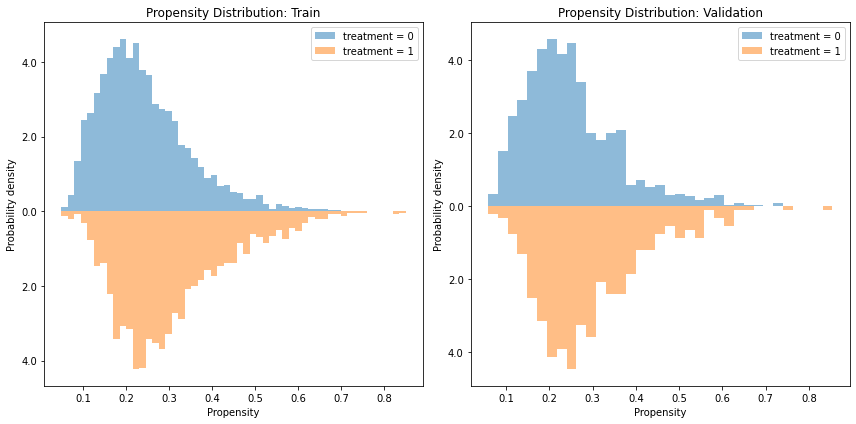

In [5]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_weight_distribution(reflect=True, ax=a0)
results.plot_weight_distribution(reflect=True, phase="valid", ax=a1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
plt.tight_layout();

### ROC and Precision-Recall Curves

ROC curves are interpreted differently for propensity scores in a way that can be unintuitive for practitioners used to apply it to classifiers. 
For a deeper dive on the subject, you can refer to [this blog post](https://medium.com/towards-data-science/using-machine-learning-metrics-to-evaluate-causal-inference-models-d066f1bb2b7a).   
Briefly - too good of an AUC (and sharp vertical/horizontal lines) might suggest the groups are too separated and therefore violate the positivity violation.
Too poor of an AUC might be a good sign that the groups are well-mixed and overlap.  

Furthermore, we can have additional ROC curves.
Mainly, the "weighted" ROC curve is a post-balancing curve. 
Therefore, if the model did a good job at balancing the groups, they should be indistinguishable and therefore the corresponding curve should align on the diagonal (chance curve).
Secondly, the "expected" ROC curve also has a probability-calibration to it, as it presents a "soft" curve, where each propensity score doesn't count toward either a true-positive or a false-positive, but rather contributes $p$ to the TP and $1-p$ to the FP.
Consequently, it should align with the original ROC curve if the model is well-specified.

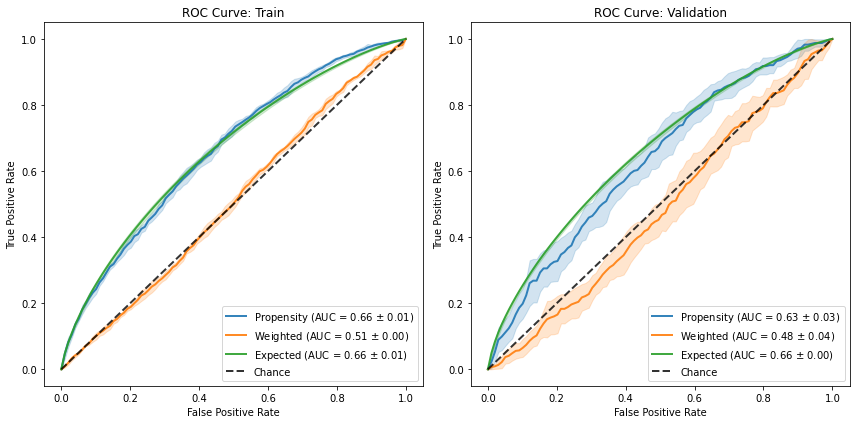

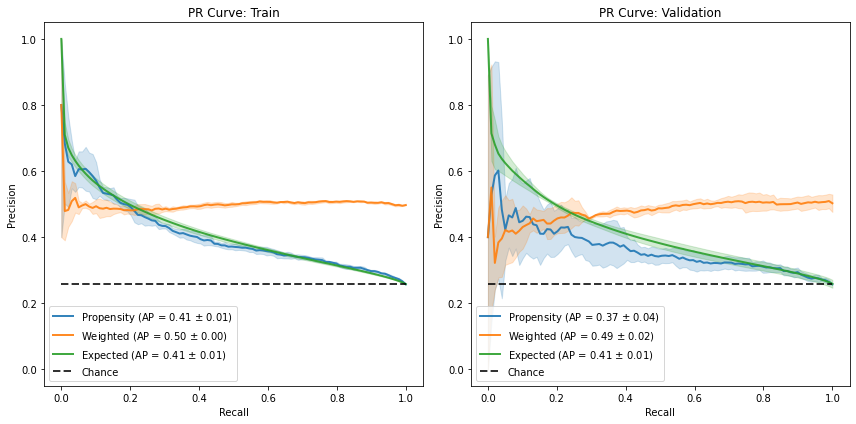

In [6]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_roc_curve(ax=a0)
results.plot_roc_curve(phase="valid", ax=a1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
plt.tight_layout();

fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_pr_curve(ax=a0)
results.plot_pr_curve(phase="valid", ax=a1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
plt.tight_layout();

### Calibration
Because the propensity score is supposed to represent a probability, we want to verify that it is indeed calibrated with the observed probabilities.

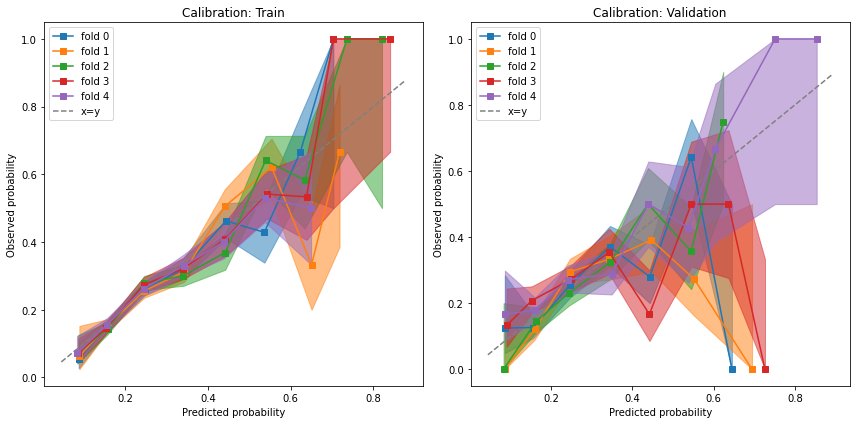

In [7]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_calibration_curve(ax=a0)
results.plot_calibration_curve(phase="valid", ax=a1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
plt.tight_layout();

## Outcome model plots (continuous)

In [8]:
cont_std = StratifiedStandardization(LinearRegression())
cont_std.fit(data.X, data.a, data.y)
cont_std_results = evaluate(cont_std, data.X, data.a, data.y, cv="auto")
cont_std_results.all_plot_names

frozenset({'common_support', 'continuous_accuracy', 'residuals'})

### Continuous accuracy and residuals

`IndividualOutcomeEstimator` models are essentially regression models and can be assessed for how well they predict the observed outcomes. 
Basically, we can compare the predicted with the observed values, like we would with a regular prediction model.
This is a positive-control kind of a test. It does not guarantee the models predict counterfactual outcome correct, but at-least we can ensure they are not blatantly wrong. 

The continuous accuracy plot compares the predictions with observed values. With a perfect model, all points would be along the dashed `x=y` line.  
The residual plot is the difference between the observed value and the predicted value. With a perfect model, all points would be along the dashed `y=0` line. 
More importantly, the residual distribution should be similar across groups. 
If one group has biased residuals (e.g., mean 0 for the control and mean 1 for the treated), it might sneak in bias to the effect estimation that contrasts the two counterfactual predictions.

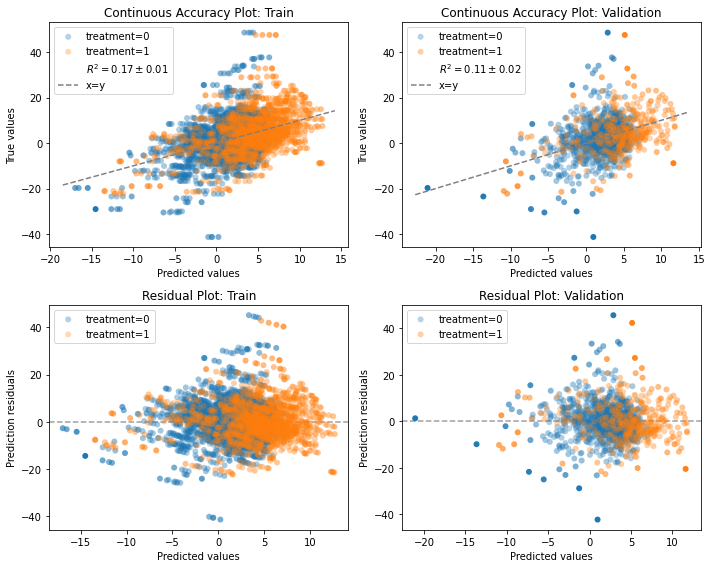

In [9]:
f, axes = plt.subplots(2, 2, figsize=(10, 8))
row1, row2 = axes
cont_std_results.plot_continuous_accuracy(phase="train", ax=row1[0])
cont_std_results.plot_continuous_accuracy(phase="valid", ax=row1[1])
cont_std_results.plot_residuals(phase="train", ax=row2[0])
cont_std_results.plot_residuals(phase="valid", ax=row2[1])
plt.tight_layout()

# to add the train validation annotation to the titles:
for row in axes: 
    for idx, suffix in [(0, "Train"), (1 ,"Validation")]:
        row[idx].set_title(row[idx].get_title() + ": " + suffix)


### Common support

Ideally, we would like to plot the potential outcomes $Y^0, Y^1$ to check whether the exchangeability assumption $Y^0,Y^1 \perp A$ holds.
Unfortunately, we don't have access to the true potential outcomes, so our best way to imitate them is with the counterfactual prediction.
We visually test for $\hat{Y}^0, \hat{Y}^1 \perp A$ by plotting a scatter plot (each dot is a unit) colored by the observed treatment assignment, and seeing whether, overall, the two groups overlap.
Failing to overlap may suggest there's a problem with how our model is consistent across treatment groups, and therefore we need to be even more cautious with a causal interpretation of the results.

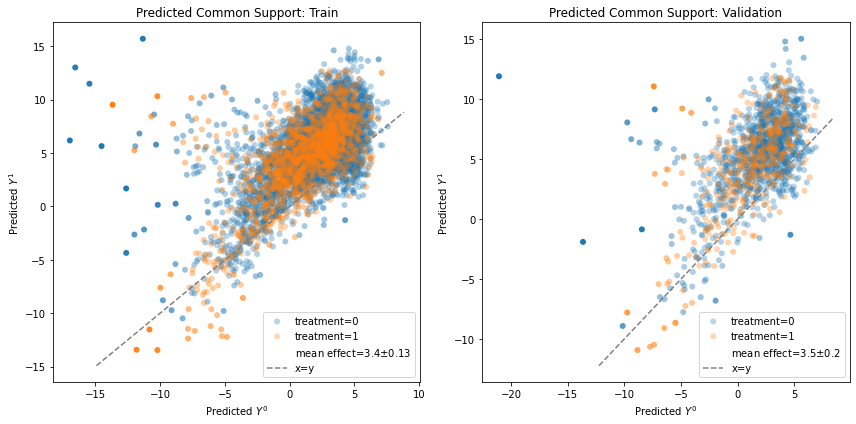

In [10]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
cont_std_results.plot_common_support(phase="train", ax=a0)
cont_std_results.plot_common_support(phase="valid", ax=a1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
_ = plt.tight_layout()

## Outcome model plots (binary)

In [11]:
# We generate some simple binary outcomes based on the original data
y = 1 / (1 + np.exp(-data.y))
y = np.random.binomial(1, y)
y = pd.Series(y, index=data.a.index)

In [12]:
bin_std = StratifiedStandardization(LogisticRegression(max_iter=2000))
bin_std.fit(data.X, data.a, y)
bin_std_results = evaluate(bin_std, data.X, data.a, y, cv="auto")
bin_std_results.all_plot_names

frozenset({'calibration', 'pr_curve', 'roc_curve'})

### ROC, PR and Calibration

Binary outcome models have plots for assessing the quality of their predictions. 
The plots are the same as for the propensity models because treatment assignment is essentially a binary outcome prediction. 
The interpretation, however, is different and easier - as we interpret these like we would a regular classification task.  
The classification results are broken down by treatment group to help identify whether we model both groups comparably.
Modeling the full response surface is a hard task and it is not unthinkable to misspecify one of the groups.

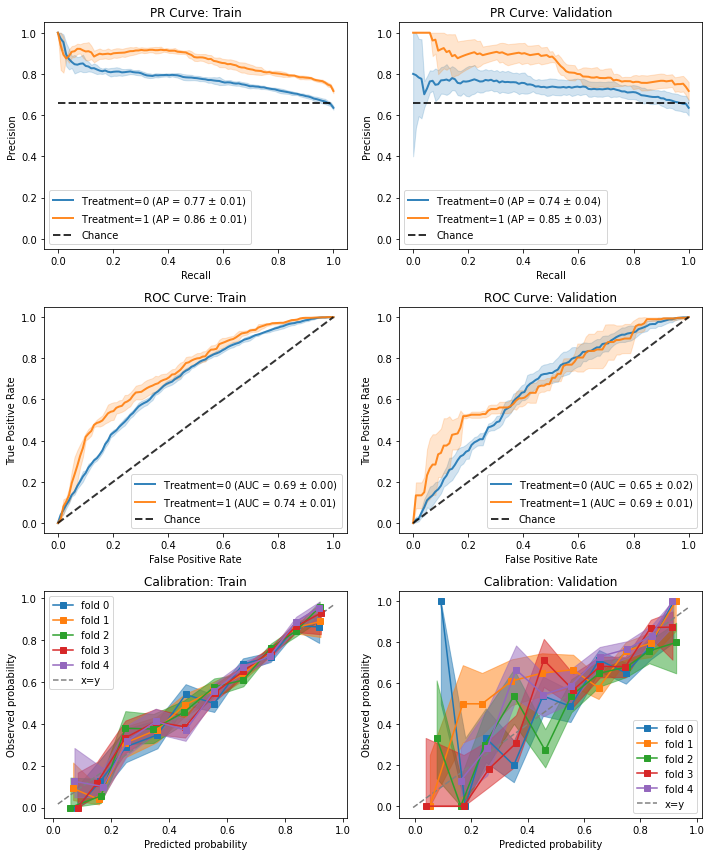

In [13]:
f, axes = plt.subplots(3, 2, figsize=(10, 12))
row1, row2, row3 = axes
bin_std_results.plot_pr_curve(phase="train", ax=row1[0])
bin_std_results.plot_pr_curve(phase="valid", ax=row1[1])
bin_std_results.plot_roc_curve(phase="train", ax=row2[0])
bin_std_results.plot_roc_curve(phase="valid", ax=row2[1])
bin_std_results.plot_calibration_curve(phase="train", ax=row3[0])
bin_std_results.plot_calibration_curve(phase="valid", ax=row3[1])
plt.tight_layout()

# to add the train validation annotation to the titles:
for row in axes: 
    for idx, suffix in [(0, "Train"), (1 ,"Validation")]:
        row[idx].set_title(row[idx].get_title() + ": " + suffix)


## Non-propensity weight model plots
There are some models which are weight models but not based on inverse propensity weighting, such as the `AdversarialBalancing` model. For this model, plots assessing the quality of the binary prediction of treatment assignment are not relevant, but weight plots are still relevant. For this demo, we compare the plots of the `AdversarialBalancing` model with the `IPW` plots.

In [14]:
from causallib.contrib.adversarial_balancing import AdversarialBalancing

ipw_model = IPW(LogisticRegression(solver="liblinear"))
ipw_model.fit(data.X, data.a, data.y)
ipw_evaluate = evaluate(ipw_model, data.X, data.a, data.y, cv="auto")

ab_model = AdversarialBalancing(LogisticRegression(solver="liblinear"))
ab_model.fit(data.X, data.a, data.y)
ab_evaluate = evaluate(ab_model, data.X, data.a, data.y, cv="auto", metrics_to_evaluate={})

ab_evaluate.all_plot_names

frozenset({'covariate_balance_love',
           'covariate_balance_slope',
           'weight_distribution'})

### Covariate balance
We see that the `AdversarialBalancing` model successfully reduces the covariate imbalance to 0 in the train phase
but does not necessarily generalize so well in the validation phase.

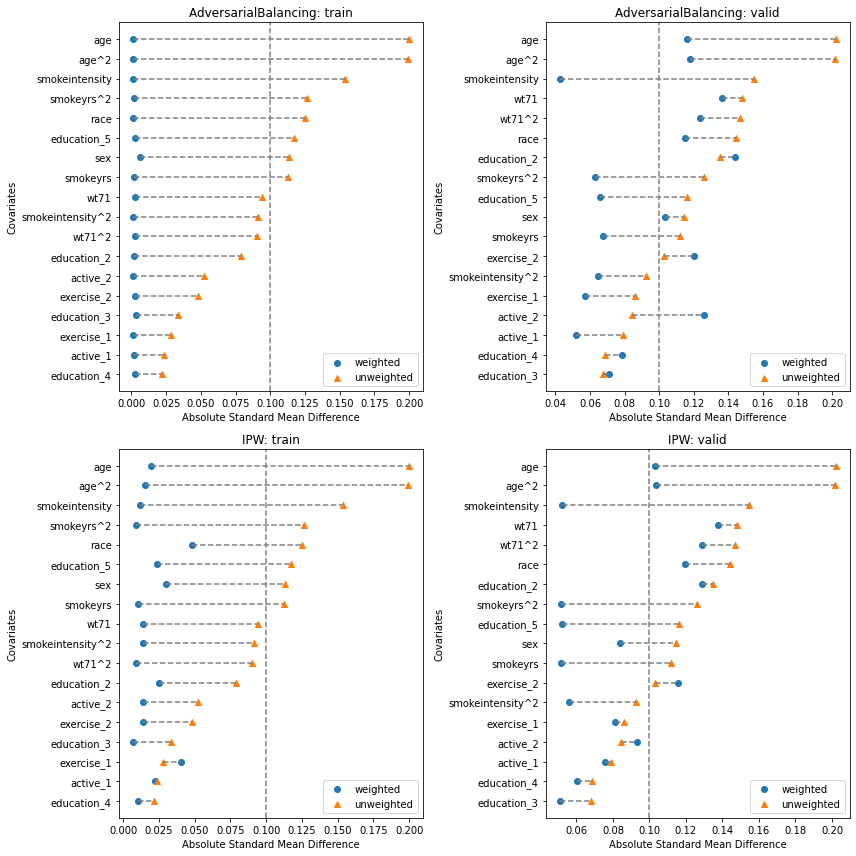

In [15]:
f, [row1, row2] = plt.subplots(2, 2, figsize=(12,12))
thresh=0.1
ab_evaluate.plot_covariate_balance(phase="train", thresh=thresh, ax=row1[0])
row1[0].set_title("AdversarialBalancing: train")
ab_evaluate.plot_covariate_balance(phase="valid", thresh=thresh, ax=row1[1])
row1[1].set_title("AdversarialBalancing: valid")
ipw_evaluate.plot_covariate_balance(phase="train", thresh=thresh, ax=row2[0])
row2[0].set_title("IPW: train")
ipw_evaluate.plot_covariate_balance(phase="valid", thresh=thresh, ax=row2[1])
row2[1].set_title("IPW: valid");
plt.tight_layout()

We can drill down a little more and see that the number of imbalanced features is almost always lower for the `IPW` model compared to the `AdversarialBalancing` model, though their performance is very close in the validation phase. Experimenting with different learners may yield different results.

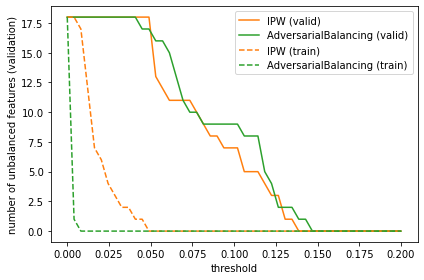

In [16]:
def unbalanced_feature_count(covbalance, thresh=0.1, phase="valid"):
    return sum(covbalance.loc[phase].groupby(level=1).mean()["weighted"] > thresh)

thresh_range = np.linspace(0, 0.2)
plt.plot(thresh_range, [unbalanced_feature_count(ipw_evaluate.evaluated_metrics.covariate_balance, t) for t in thresh_range], label="IPW (valid)", color="C1")
plt.plot(thresh_range, [unbalanced_feature_count(ab_evaluate.evaluated_metrics.covariate_balance, t) for t in thresh_range], label="AdversarialBalancing (valid)", color="C2")
plt.plot(thresh_range, [unbalanced_feature_count(ipw_evaluate.evaluated_metrics.covariate_balance, t, "train") for t in thresh_range], label="IPW (train)", color="C1", ls="--")
plt.plot(thresh_range, [unbalanced_feature_count(ab_evaluate.evaluated_metrics.covariate_balance, t, "train") for t in thresh_range], label="AdversarialBalancing (train)", color="C2", ls="--")
plt.ylabel("number of unbalanced features (validation)")
plt.xlabel("threshold")
plt.legend()
_ = plt.tight_layout()

### Weight distribution
For non-propensity weights, plotting the weights is slightly more awkward, but we may still look for overlap between the treatment groups. 

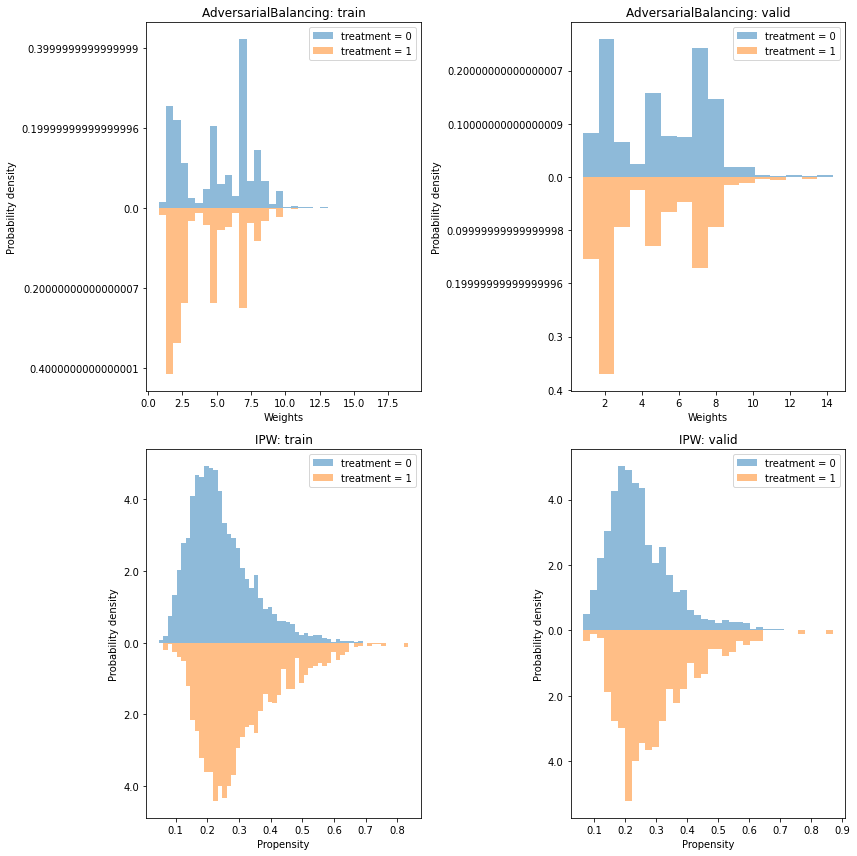

In [17]:
f, [row1, row2] = plt.subplots(2, 2, figsize=(12,12))
ab_evaluate.plot_weight_distribution(phase="train", ax=row1[0])
row1[0].set_title("AdversarialBalancing: train")
ab_evaluate.plot_weight_distribution(phase="valid", ax=row1[1])
row1[1].set_title("AdversarialBalancing: valid")
ipw_evaluate.plot_weight_distribution(phase="train", ax=row2[0])
row2[0].set_title("IPW: train")
ipw_evaluate.plot_weight_distribution(phase="valid", ax=row2[1])
row2[1].set_title("IPW: valid")
_ = plt.tight_layout()